# Experimento com RSVD em Sistema de Recomendação

## Imports

Importação das bibliotecas que serão utilizadas para lidar com o banco de dados e com a matemática.

In [1]:
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

## Importando e tratando o Dataset
Utilizando o pandas para pegar o dataset do Movielens com 100 mil notas.

In [2]:
ratingsDf = pd.read_csv('../../data/ml-100k/u.data', sep='\t', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'])
ratingsDf

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [3]:
# Criando a matriz que relaciona as avaliações (usuários x filmes)
num_users = ratingsDf['user_id'].nunique()
num_movies = ratingsDf['movie_id'].nunique()
ratings_tuples = []

# Preenchendo a matriz com as avaliações dos usuários
for row in ratingsDf.itertuples(index=False):
    user_idx = row.user_id - 1  # Ajustando o índice do usuário
    movie_idx = row.movie_id - 1  # Ajustando o índice do filme
    ratings_tuples.append([user_idx, movie_idx, row.rating])

ratings_tuples

[[195, 241, 3],
 [185, 301, 3],
 [21, 376, 1],
 [243, 50, 2],
 [165, 345, 1],
 [297, 473, 4],
 [114, 264, 2],
 [252, 464, 5],
 [304, 450, 3],
 [5, 85, 3],
 [61, 256, 2],
 [285, 1013, 5],
 [199, 221, 5],
 [209, 39, 3],
 [223, 28, 3],
 [302, 784, 3],
 [121, 386, 5],
 [193, 273, 2],
 [290, 1041, 4],
 [233, 1183, 2],
 [118, 391, 4],
 [166, 485, 4],
 [298, 143, 4],
 [290, 117, 2],
 [307, 0, 4],
 [94, 545, 2],
 [37, 94, 5],
 [101, 767, 2],
 [62, 276, 4],
 [159, 233, 5],
 [49, 245, 3],
 [300, 97, 4],
 [224, 192, 4],
 [289, 87, 4],
 [96, 193, 3],
 [156, 273, 4],
 [180, 1080, 1],
 [277, 602, 5],
 [275, 795, 1],
 [6, 31, 4],
 [9, 15, 4],
 [283, 303, 4],
 [200, 978, 2],
 [275, 563, 3],
 [286, 326, 5],
 [245, 200, 5],
 [241, 1136, 5],
 [248, 240, 5],
 [98, 3, 5],
 [177, 331, 3],
 [250, 99, 4],
 [80, 431, 2],
 [259, 321, 4],
 [24, 180, 5],
 [58, 195, 5],
 [71, 678, 2],
 [86, 383, 4],
 [289, 142, 5],
 [41, 422, 5],
 [291, 514, 4],
 [114, 19, 3],
 [19, 287, 1],
 [200, 218, 4],
 [12, 525, 3],
 [245, 9

In [4]:
# Pegando avaliações para usar de teste
x_test = ratingsDf.sample(n=5000, random_state=123)

# Transformando em NaN na matriz de notas os valores de teste
for _ , row in x_test.iterrows():
    ratings_tuples.remove([row.user_id - 1, row.movie_id - 1, row.rating])

## Classe do RSVD

In [5]:
class RSVD:
    def __init__(self, lenUsers, lenMovies, k=3, learning_rate=0.01, regularization=0.02, iterations=100):
        self.k = k
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.iterations = iterations
        self.P = None
        self.Q = None
        self.error = float('inf')
        self.lenUsers = lenUsers
        self.lenMovies = lenMovies
    
    def fit(self, ratings):
        # Inicializando P e Q caso não estejam inicializadas
        if self.P is None:
            self.P = np.random.rand(self.lenUsers, self.k)
            self.Q = np.random.rand(self.k, self.lenMovies)

        idx = list(range(len(ratings)))
        random.shuffle(idx)

        print(f"Iterando com k igual a {self.k}")
        for _ in tqdm(range(self.iterations)):
            total_error = 0.0

            for i in idx:
                u, v, r = ratings[idx[i]]
                # Cálculo do erro
                e = r - self.predict(u, v)

                # Atualizando variáveis latentes
                P = self.P[u, :]
                Q = self.Q[:, v]
                self.P[u, :] += self.learning_rate * (e * Q - self.regularization * P)
                self.Q[:, v] += self.learning_rate * (e * P - self.regularization * Q)

                total_error += (np.power(e, 2) + self.learning_rate * (np.power(np.linalg.norm(self.Q[:, v]), 2) + np.power(np.linalg.norm(self.P[u, :]), 2)))

            if total_error > self.error:
                break

            self.error = total_error

    def predict(self, user_id, item_id):
        prediction = np.dot(self.P[user_id, :], self.Q[:, item_id])
        return prediction

In [6]:
def get_errors(RSVD, y, x_test):
    predictedValues = []
    
    for _ , row in x_test.iterrows():
        predictedValues = np.append(predictedValues, RSVD.predict(row.user_id - 1, row.movie_id - 1))

    rmse = math.sqrt(np.mean((predictedValues - y) ** 2))
    mae = np.mean(np.abs(predictedValues - y))
        
    return rmse, mae

In [7]:
x_test.sort_values(by=['user_id', 'movie_id'], inplace=True)
y = np.array(x_test['rating'])

k_range = range(1, 10)
rmse_euclidean = []
mae_euclidean = []
rmseArr = []
maeArr = []

for k in k_range:
    rsvd = RSVD(943, 1682, k)
    rsvd.fit(ratings_tuples)
    rmse, mae = get_errors(rsvd, y, x_test)
    rmseArr.append(rmse)
    maeArr.append(mae)

Iterando com k igual a 1


  0%|          | 0/100 [00:00<?, ?it/s]

 50%|█████     | 50/100 [02:05<02:05,  2.51s/it]


Iterando com k igual a 2


100%|██████████| 100/100 [03:51<00:00,  2.32s/it]


Iterando com k igual a 3


100%|██████████| 100/100 [03:56<00:00,  2.37s/it]


Iterando com k igual a 4


100%|██████████| 100/100 [03:52<00:00,  2.33s/it]


Iterando com k igual a 5


100%|██████████| 100/100 [03:59<00:00,  2.40s/it]


Iterando com k igual a 6


100%|██████████| 100/100 [04:00<00:00,  2.41s/it]


Iterando com k igual a 7


100%|██████████| 100/100 [03:59<00:00,  2.40s/it]


Iterando com k igual a 8


100%|██████████| 100/100 [04:05<00:00,  2.46s/it]


Iterando com k igual a 9


100%|██████████| 100/100 [04:05<00:00,  2.46s/it]


In [8]:
globalMean = np.mean(ratings_tuples, axis=0)[2]
predicted_global = [globalMean for _ in range(len(y))]


rmse_global = math.sqrt(np.mean((predicted_global - y) ** 2))
rmse_global_arr = [rmse_global for _ in range(len(rmseArr))]

mae_global = np.mean(np.abs(predicted_global - y))
mae_global_arr = [mae_global for _ in range(len(maeArr))]

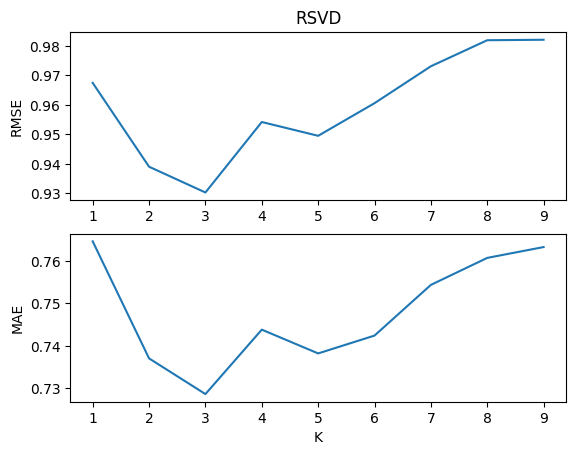

In [10]:
fig, ax = plt.subplots(2)
ax[0].plot(k_range, rmseArr)
ax[0].set_title("RSVD")
ax[0].set_ylabel("RMSE")
ax[1].plot(k_range, maeArr)
ax[1].set_xlabel("K")
ax[1].set_ylabel("MAE")

plt.show()

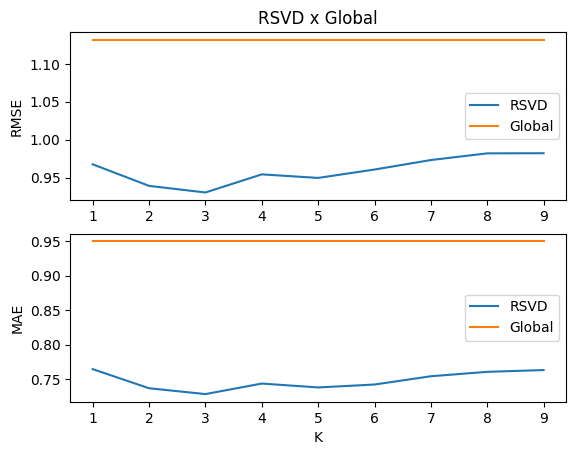

In [9]:
fig, ax = plt.subplots(2)
ax[0].plot(k_range, rmseArr)
ax[0].set_title("RSVD x Global")
ax[0].set_ylabel("RMSE")
ax[0].plot(k_range, rmse_global_arr)
ax[0].legend(["RSVD", "Global"])
ax[1].plot(k_range, maeArr)
ax[1].set_xlabel("K")
ax[1].set_ylabel("MAE")
ax[1].plot(k_range, mae_global_arr)
ax[1].legend(["RSVD", "Global"])

plt.show()